## Análise de dados do Experimento 1 - Física Experimental V
Grupo GD18

## Dependências e definições

In [2]:
import numpy as np
import pandas as pd
import os
import scipy
import scipy.stats as st
import scipy.odr as odr
import re
import uncertainties as unc
import uncertainties.unumpy as unp
import matplotlib.pyplot as plt
import scipy.optimize as opt
from matplotlib.offsetbox import AnchoredText

In [3]:
# Caminho para as pastas contendo os arquivos de dados

base_path = os.path.expanduser("~/Lab5")
sem1_path = os.path.join(base_path, "Lab5_Exp1_Sem1_GD18")
sem2_path = os.path.join(base_path, "Lab5_Exp1_Sem2_GD18")
sem3_path = os.path.join(base_path, "Lab5_Exp1_Sem3_GD18")

output_path = os.path.join(base_path, "Resultados/Exp1")

In [4]:
FWHM = 2.355

In [5]:
# Dicionários para fazer a correspondência entre os nomes dos arquivos e as variavéis na base da dados
tipo_luz_dict = {"0": "Vermelho", "1": "Amarelo", "2": "Verde", "3": "Azul", "4": "Violeta", "5": "UV"}
tipo_luz2_dict = {"uv": "UV", "Azul": "Azul", "Verde": "Verde", "Amarelo": "Amarelo", "vermelho": "Vermelho",
                  "Violeta": "Violeta", "UV": "UV", "escuro": "Escuro"}


sem1_luz_dict = {"Luz": {"UV": unc.ufloat(365.016e-9, 100e-10), "Violeta": unc.ufloat(404.656e-9, 100e-10),
                 "Azul": unc.ufloat(436.835e-9, 100e-10), "Verde": unc.ufloat(546.075e-9, 100e-10),
                 "Amarelo": unc.ufloat(576.96e-9, 100e-10), "Vermelho": unc.ufloat(614.950e-9, 100e-10)}}

sem2_luz_dict = {"Luz": {4055.0: unc.ufloat(4055e-10, 100e-10 / FWHM), 4370.0: unc.ufloat(4370e-10, 100e-10 / FWHM),
                 5470.0: unc.ufloat(5470e-10, 90e-10 / FWHM), 5780.0: unc.ufloat(5780e-10, 80e-10 / FWHM),
                 6900.0: unc.ufloat(6900e-10, 90e-10 / FWHM)}}

sem3_luz_dict = {"Luz": {"azul": unc.ufloat(467e-9, 24e-9 / FWHM), "verde": unc.ufloat(506e-9, 13e-9 / FWHM),
                 "amarelo": unc.ufloat(594e-9, 16e-9), "vermelho": unc.ufloat(630e-9, 21e-9),
                 "infravermelho": unc.ufloat(930e-9, 53e-9)}}

# Colunas no arquivo .csv
colunas = ["tensao", "corrente"]

## Inicialização dos dados

### Carregamento

In [6]:
# Variável para conter todos os dados sem pós-processamento
raw_data = pd.DataFrame()

# Carregar dados da semana 1
sem1_files = os.listdir(sem1_path)
sem1_filepaths = [os.path.join(sem1_path, file) for file in sem1_files]


for i in range(0, len(sem1_files)):
    file = sem1_files[i]
    filepath = sem1_filepaths[i]
    
    # Ignorar arquivos que não sejam .csv
    if file[-4:] != ".csv":
        continue
    
    file_params = file.split("_")
    if len(file_params) == 4:
        intensidade = file_params[0]
        tipo_luz = file_params[2]
        luz_dict = tipo_luz_dict
        tomada = "sem1"
    elif len(file_params) == 2:
        intensidade = re.findall(r'\d+', file_params[0])[0]
        tipo_luz = re.findall(r'[a-zA-Z]+', file_params[0])[0]
        luz_dict = tipo_luz2_dict
        tomada = "rogerio"
        if tipo_luz == "escuro":
            intensidade = 0
    
    iter_data = pd.read_csv(filepath, delimiter=";", decimal=",", names=colunas, skiprows=1)
    iter_data["intensidade"] = int(intensidade)
    iter_data["luz"] = luz_dict[tipo_luz]
    iter_data["tomada"] = tomada
    raw_data = raw_data.append(iter_data)

In [7]:
# Carregar dados da semana 2
sem2_files = os.listdir(sem2_path)
sem2_filepaths = [os.path.join(sem2_path, file) for file in sem2_files]
for i in range(0, len(sem2_files)):
    file = sem2_files[i]
    filepath = sem2_filepaths[i]
    
    # Ignorar arquivos que não sejam .csv
    if file[-4:] != ".csv":
        continue
    
    file_params = file.split("_")
    
    if len(file_params) > 2:
        intensidade = file_params[0]
        iter_data = pd.read_csv(filepath, delimiter=";", decimal=",", names=colunas, skiprows=1)
        if len(file_params) == 4:
            comprimento_onda = file_params[2]
            iter_data["luz"] = float(comprimento_onda)
    else:
        continue        

    iter_data["intensidade"] = int(intensidade)
    iter_data["tomada"] = "sem2"
    raw_data = raw_data.append(iter_data)

In [8]:
# Carregar dados da semana 3
sem3_files = os.listdir(sem3_path)
sem3_filepaths = [os.path.join(sem3_path, file) for file in sem3_files]
for i in range(0, len(sem3_files)):
    file = sem3_files[i]
    filepath = sem3_filepaths[i]
    
    # Ignorar arquivos que não sejam .csv
    if file[-4:] != ".csv":
        continue
    
    file_params = file.split("_")
    
    if len(file_params) > 2:
        intensidade = file_params[0]
        iter_data = pd.read_csv(filepath, delimiter=";", decimal=",", names=colunas, skiprows=1)
        if len(file_params) == 4:
            comprimento_onda = file_params[2]
            iter_data["luz"] = comprimento_onda
    else:
        continue        

    iter_data["intensidade"] = int(intensidade)
    iter_data["tomada"] = "sem3"
    raw_data = raw_data.append(iter_data)

In [9]:
raw_data = raw_data.sort_values(by="tensao")
raw_data = raw_data.reset_index(drop=True)

### Pós processamento inicial

In [10]:
# Agrupar dados por tomada, tipo de luz, tensão e intensidade
gs = raw_data.groupby(["tomada", "luz", "tensao", "intensidade"])

# Usar desvio padrão da média como incerteza da corrente
incerteza_corrente = gs.std() / np.sqrt(gs.count() - 1)
incerteza_corrente = incerteza_corrente.rename(columns={"corrente": "std_corrente"})

# Colocar uma coluna de contagem para cada agrupamento
count_corrente = gs.count()
count_corrente = count_corrente.rename(columns={"corrente": "qtd_corrente"})

# Juntar tudo
grouped_data = gs.mean()
grouped_data = pd.concat([grouped_data, incerteza_corrente], axis=1, copy=True)
grouped_data = pd.concat([grouped_data, count_corrente], axis=1, copy=True)

#### Filtro de outliers

In [11]:
# Usar somente pontos agrupados com 3 ou mais pontos
grouped_data = grouped_data[grouped_data.qtd_corrente >= 3]

## Análise de dados

### Funções para análise de dados

#### Funções genéricas

In [12]:
def interpolate(data):
    """Função para interpolar rápido algo."""
    cs = scipy.interpolate.CubicSpline(x=data[0], y=data[1])
    x = np.linspace(-5, 5, 1000)
    y = cs(x)
    return np.array([x, y])


def linear_function(x, A, b):
    """Modelo para fazer fit em função linear."""
    return A * x + b

#### Funções para visualização de dados

In [13]:
def visualizar(sem_data, savefile="", semana=""):
    luzes = pd.unique(sem_data.luz)
    fig, axes = plt.subplots(len(luzes), 5, sharex=True)
    fig.set_size_inches(30, 30)
    for i in range(len(luzes)):
        luz = luzes[i]
        luz_data = sem_data[sem_data.luz == luz]
        intensidades = pd.unique(luz_data.intensidade)
        for j in range(len(intensidades)):
            intensidade = intensidades[j]
            intensidade_data = luz_data[luz_data.intensidade == intensidade]
            ax = axes[i, j]
            x = intensidade_data.tensao
            y = intensidade_data.corrente
            yerr = 1 * intensidade_data.std_corrente
            ax.plot(x, y, "x")
            ax.fill_between(x, y-yerr, y+yerr, alpha=0.3)
            ax.set_title("{}, intensidade {}%".format(luz, intensidade))

    fig.text(0.5, 0.9, "Curva característica (tomada: {})".format(semana), ha='center', size="30")
    fig.text(0.5, 0.1, "Tensão (V)", ha='center', size="20")
    fig.text(0.1, 0.5, 'Corrente (A)', va='center', rotation='vertical', size="20")
    if savefile != "":
        plt.savefig(savefile, odpi=300)
    else:
        plt.show()
    plt.close()

#### Funções para aquisição de $V_0$

In [14]:
def metodo1(x, y, yerr, plot=False, savefile=""):
    """Método para obter V0 utilizando-se do critério de corrente ser nula."""
    
    # Estimar a incerteza na variável x usando dist. uniforme
    xerr = np.median(np.diff(x)) / np.sqrt(12)
    
    # Índice mais próximo de Y=0
    [xi, yi] = interpolate([x, y])
    iy_min = np.argmin(np.abs(yi))
    V0 = xi[iy_min]
    
    # Propagação de incerteza
    V0 = unc.ufloat(V0, xerr)
    
    # É o plot, é o plot, é o plot
    if ((plot is True) or (savefile != "")):
        plt.figure(figsize=(14, 7))
        plt.errorbar(x, y, yerr=yerr, fmt=".", label="I(A)")
        plt.title("Aquisição de $V_0$ pelo método da corrente nula")
        plt.xlabel("Tensão (V)")
        plt.ylabel("Corrente (A)")
        plt.axvline(V0.n, color="r", linestyle="--", label=r"$V_0$: {} V".format(V0))
        plt.grid()
        plt.legend()
        if (savefile != ""):
            plt.savefig(savefile, odpi=300)
        if (plot is True):
            plt.show()
        else:
            plt.close()
    
    return V0
    
def metodo2(x, y, yerr, plot=False, savefile=""):
    """Método para obter V0 pela interceptação de ajustes lineares no ponto da corrente linear."""
    
    # Intervalo do primeiro ajuste - corrente abaixo de zero
    i1 = (x < -0.8)
    
    # Intervalo do segundo ajuste
    i2 = (x >= -0.3)
    i2 &= (x <= 0)
    
    # Não vai rolar ajuste se tiver menos que 2 pontos.
    if((np.sum(i1) < 2) or (np.sum(i2) < 2)):
        return unc.ufloat(np.nan, np.nan)
    
    # Cada ajuste no seu quadrado
    ajuste_1 = opt.curve_fit(linear_function, x[i1], y[i1], sigma=yerr[i1])
    ajuste_2 = opt.curve_fit(linear_function, x[i2], y[i2], sigma=yerr[i2])
    
    # Propagação automática de incertezas
    (a1, b1) = unc.correlated_values(ajuste_1[0], ajuste_1[1])
    (a2, b2) = unc.correlated_values(ajuste_2[0], ajuste_2[1])
        
    # Tirar a inteceptação pela geometria dos parâmetros
    V0 = (b2 - b1)
    V0 /= (a1 - a2)
    
    if (pd.isnull(V0.s)):
        V0 = unc.ufloat(V0.n, np.median(np.diff(x)) / np.sqrt(12))

    # Aquela plotada violenta
    if ((plot is True) or (savefile != "")): 
        x1 = x[x <= V0.n]
        x2 = x[(x <= 0) & (x >= V0.n)]
        ind = x <= 0
        xp = x[ind]
        yp = y[ind]
        yp_err = yerr[ind]
        y1 = apply_fit(linear_function, x1, ajuste_1, sigma=1.0)
        y2 = apply_fit(linear_function, x2, ajuste_2, sigma=1.0)
        plt.figure(figsize=(14, 7))    
        
        plt.plot(x1, y1[0], label="Ajuste para tensão abaixo de -0.8V")
        plt.fill_between(x1, y1[0] - y1[1], y1[0] + y1[1], alpha=0.3)
        plt.plot(x2, y2[0], label=r"Ajuste em [-0.3, 0] V")
        plt.fill_between(x2, y2[0] - y2[1], y2[0] + y2[1], alpha=0.3)
        
        plt.errorbar(xp, yp, yerr=yp_err, fmt=".", label="I(A)")
        plt.title("Aquisição de $V_0$ pelo método dos ajustes lineares")
        plt.xlabel("Tensão (V)")
        plt.ylabel("Corrente (A)")
        plt.axvline(V0.n, color="r", linestyle="--", label="$V_0 (V)$ = {}".format(V0))
        plt.grid()
        plt.legend()
        if (savefile != ""):
            plt.savefig(savefile, odpi=300)
        if (plot is True):
            plt.show()
        else:
            plt.close()
        
    return V0
    
    
def metodo3(x_list, y_list, yerr_list, plot=False, savefile=""):
    "Método para obter V0 pela média da intersecção entre as curvas"
    qtd_curvas = len(x_list)    
    N = np.cumsum(np.arange(5))
    x_intercept_points = []
    y_intercept_points = []
    
    if ((plot is True) or (savefile != "")):
        plt.figure(figsize=(14, 7))
    
    for i in range(qtd_curvas):
        data_1 = interpolate([x_list[i], y_list[i]])
        for j in range(qtd_curvas - i):
            data_2 = interpolate([x_list[j], y_list[j]])
            y_dif = np.abs(data_1[1, :] - data_2[1, :])
            iy_min = np.argmin(y_dif)
            x_intercept = data_1[0, iy_min]
            y_intercept = data_1[1, iy_min]
            x_intercept_points.append(x_intercept)
            y_intercept_points.append(y_intercept)
            if ((plot is True) or (savefile != "")):
                plt.plot(*data_2, "-k")
    
    x_arr = np.array(x_intercept_points)
    y_arr = np.array(y_intercept_points)
    ind = (x_arr < 0) & (x_arr > -2.5)
    x_arr = x_arr[ind]
    y_arr = y_arr[ind]
    V0 = unc.ufloat(np.mean(x_arr), np.std(x_arr))
    if (pd.isnull(V0.s)):
        V0 = unc.ufloat(np.mean(x_arr), np.median(np.diff(x_list[0])) / np.sqrt(12))
        
    if ((plot is True) or (savefile != "")):
        plt.title("Aquisição de $V_0$ pelo método das intersecções das curvas")
        plt.xlabel("Tensão (V)")
        plt.ylabel("Corrente (A)")
        plt.plot(x_arr, y_arr, 'rx', label="Intersecções")
        plt.axvline(V0.n, color="r", linestyle="--", label="$V_0$ = {}V".format(V0))
        plt.legend()
        if (savefile != ""):
            plt.savefig(savefile, odpi=300)
        if (plot is True):
            plt.show()
        else:
            plt.close()

    return V0
            
def metodo4(x, y, yerr, plot=False, savefile="", sigma=3.0, n=1, tensao_magica=-9999):
    """Método para obter V0 através da detecção de outliers na segunda derivada.
        Keywords Arguments:
        plot -- É para gerar uma figura e mostrar em seu GUI? Não comutativo com savefile
        savefile -- Nome do arquivo para salvar a figura. Coloque nada para sair nada
        tensao_magica -- Limite da tensão a ser considerada ao ajustar o modelo linear
        sigma -- Múltiplos do desvio-padrão do ajuste necessário para caracterizar V0"""
    if tensao_magica < -20:
        min_tensao = np.min(x)
        if min_tensao < -2.0:
            tensao_magica = -3.0
        elif min_tensao < -1.5:
            tensao_magica = -1.0
        elif min_tensao < -0.5:
            tensao_magica = -0.8
    
    # Estimativa para a incerteza na tensão via dist. uniforme
    dx = np.median(np.diff(x))
    xerr = dx / np.sqrt(12)
    
    # Tirando um elemento no começo e no final só para dar a dimensão certa na hora da derivada
    xd = x[1:-1]
    
    # A derivada
    y = unp.uarray(y, yerr)
    yd = (y[2:] - 2 * y[1:-1] + y[:-2]) / dx ** 2
    
    xd = pd.Series(xd).rolling(window=n).mean()[n:]
    yd_nom = pd.Series(unp.nominal_values(yd)).rolling(window=n).mean()[n:]
    yd_err = pd.Series(unp.std_devs(yd)).rolling(window=n).mean()[n:]
    yd = unp.uarray(yd_nom, yd_err)
    
    # Delimitar o intervalo do ajuste linear utilizando para achar o outlier
    x_aj = xd[xd < tensao_magica]
    y_aj= yd[xd < tensao_magica]
    aj = opt.curve_fit(linear_function, x_aj, unp.nominal_values(y_aj), sigma=unp.std_devs(y_aj))
   
    # Aplicar os valores de tensão no ajuste linear e ver o que sai
    y_f = apply_fit(linear_function, xd, aj)
    
    y_n = y_f[0]
    yd_upb = y_f[0] + y_f[1] * sigma
    yd_lpb = y_f[0] - y_f[1] * sigma
    
    # Obter o primeiro outlier da historia
    outliers = yd - yd_upb > 0
    if np.sum(outliers) > 0:
        i_V0 = np.argmax(outliers)
        V0 = unc.ufloat(xd.iloc[i_V0], xerr)
    else:
        V0 = unc.ufloat(np.nan, np.nan)
        
    ### Hora do plot
    if ((plot is True) or (savefile != "")):
        aj_text = r"Intervalo de $ {:.0f} \sigma$.".format(sigma)
        aj_text += r" no ajuste linear dos pontos até {} V".format(tensao_magica)
        label_basetext = r"$\frac{\partial^2 I}{\partial V^2}$"
        plt.figure(figsize=(14, 7))
        plt.errorbar(xd, unp.nominal_values(yd), yerr=unp.std_devs(yd), fmt=".", label=label_basetext)
        plt.fill_between(xd, yd_upb, yd_lpb, alpha=0.2, label=aj_text)        
        plt.title("Aquisição de $V_0$ pelo método da segunda derivada")
        plt.xlabel("Tensão (V)")
        plt.ylabel("Segunda derivada da corrente $(I/V^2) * \delta x^2$")
        plt.axvline(V0.n, color="r", linestyle="--", label="$V_0$={}".format(V0))
        plt.grid()
        plt.legend()
        if (savefile != ""):
            plt.savefig(savefile, odpi=300)
        if (plot is True):
            plt.show()
        else:
            plt.close() 
    return V0

def metodo5(x, y, yerr, plot=False, savefile="", sigma=3.0, n=3):
    """Método para obter V0 através da detecção de outliers na segunda derivada.
        Keywords Arguments:
        plot -- É para gerar uma figura e mostrar em seu GUI? Não comutativo com savefile
        savefile -- Nome do arquivo para salvar a figura. Coloque nada para sair nada
        tensao_magica -- Limite da tensão a ser considerada ao ajustar o modelo linear
        sigma -- Múltiplos do desvio-padrão do ajuste necessário para caracterizar V0"""
    
    # Estimativa para a incerteza na tensão via dist. uniforme
    dx = np.median(np.diff(x))
    xerr = dx / np.sqrt(12)
    
    # Tirando um elemento no começo e no final só para dar a dimensão certa na hora da derivada
    xd = x[1:-1]
    
    # A derivada
    y = unp.uarray(y, yerr)
    yd = (y[2:] - 2 * y[1:-1] + y[:-2]) / dx ** 2
    
    xd = pd.Series(xd).rolling(window=n).mean()[n:]
    yd_nom = pd.Series(unp.nominal_values(yd)).rolling(window=n).mean()[n:]
    yd_err = pd.Series(unp.std_devs(yd)).rolling(window=n).mean()[n:]
      
    i_V0 = np.argmax(yd_nom)
    V0 = xd.iloc[i_V0]

    ### Hora do plot
    if ((plot is True) or (savefile != "")):
        label_basetext = r"$\frac{\partial^2 I}{\partial V^2}$"
        plt.figure(figsize=(14, 7))
        plt.errorbar(xd, yd_nom, yerr=yd_err, fmt=".", label=label_basetext)
        plt.title("Aquisição de $V_0$ pelo método da segunda derivada")
        plt.xlabel("Tensão (V)")
        plt.ylabel("Segunda derivada da corrente $(I/V^2) * \delta x^2$")
        plt.axvline(V0 + xerr, color="r", linestyle="--")
        plt.axvline(V0 - xerr, color="r", linestyle="--", label="$V_0={:.2e} \pm {:.2e}V$".format(V0, xerr))
        plt.grid()
        plt.legend()
        if (savefile != ""):
            plt.savefig(savefile, odpi=300)
        if (plot is True):
            plt.show()
        else:
            plt.close()
    return unc.ufloat(V0, xerr)   

def analisar(metodo, x, y, yerr, plot=False, savefile=""):
    """Wrapper para redirecionar para função certa."""
    output = None
    if metodo == 1:
        output = metodo1(x, y, yerr, plot=plot, savefile=savefile)
    elif metodo == 2:
        output = metodo2(x, y, yerr, plot=plot, savefile=savefile)
    elif metodo == 3:
        output = metodo3(x, y, yerr, plot=plot, savefile=savefile)
    elif metodo == 4:
        output = metodo4(x, y, yerr, plot=plot, savefile=savefile, n=1, sigma=20)
    elif metodo == 5:
        output = metodo5(x, y, yerr, plot=plot, savefile=savefile, n=10)
    return output

#### Funções auxiliares

In [15]:
def apply_fit(function, x, cf_out, sigma=1):
    """Pegar o resultado do scipy.optimize.curve_fit 
       junto a uma lista de números e cuspir de volta
       a função ajustada com incertezas propagadas"""
    
    params = unc.correlated_values(cf_out[0], cf_out[1])
    y_f = function(x, *params)
    y_f_n = unp.nominal_values(y_f)
    y_f_s = sigma * unp.std_devs(y_f)
    return (y_f_n, y_f_s)


def remover_fundo(grouped_data, semana):
    """Função para remover o fundo"""
    
    # Selecionar os dados correspondetes para a semana certinha
    sem_data = grouped_data.loc[semana].copy()
    sem_data = sem_data.reset_index()
    
    luzes = pd.unique(sem_data.luz)
    for luz in luzes:
        luz_indices = (sem_data.luz == luz)
        
        tensoes = pd.unique(sem_data[luz_indices].tensao)
        for tensao in tensoes:
            tensao_indices = (sem_data.tensao == tensao) & luz_indices
            tensao_data = sem_data[tensao_indices]
            
            null_row = sem_data[(tensao_data.intensidade == 0) & tensao_indices]
            if len(null_row > 0):
                sem_data.loc[tensao_indices, "corrente"] -= null_row.corrente.values
                sem_data.loc[tensao_indices, "std_corrente"] = np.sqrt(tensao_data.std_corrente.values ** 2
                                                                        + null_row.corrente.values ** 2)
            
    sem_data = sem_data[sem_data.intensidade != 0].drop("qtd_corrente", axis=1)
    return sem_data

def analyze(sem_data, savebase="NO", semana=""):
    """Função para analisar os dados de uma semana"""
    output = pd.DataFrame(columns=["Luz", "Intensidade", "V0", "sV0", "Metodo"])
    
    if "savebase" != "NO":
        visualizar(sem_data, savefile=os.path.join(savebase, "Exp1_{}.jpg").format(semana), semana=semana)

    luzes = pd.unique(sem_data.luz)
    for luz in luzes:
        luz_indices = (sem_data.luz == luz)
        luz_data = sem_data[luz_indices]
        intensidades = pd.unique(luz_data.intensidade)
        list_curvas = [[], [], []]
        for intensidade in intensidades:
            intensidade_indices = (luz_data.intensidade == intensidade)
            intensidade_data = luz_data[intensidade_indices]
            x = intensidade_data.tensao
            y = intensidade_data.corrente
            yerr = intensidade_data.std_corrente
            list_curvas[0].append(x)
            list_curvas[1].append(y)
            list_curvas[2].append(yerr)
            
            for metodo in [1, 2, 4]:
                if savebase != "NO":
                    savefile_t = "Exp1_{}_M{}_{}_{}.jpg".format(semana, metodo, luz, intensidade)
                    savefile = os.path.join(savebase, savefile_t)
                m = analisar(metodo, x, y, yerr, False, savefile)
                
                output = output.append({"Luz": luz, "Intensidade": intensidade,
                                        "V0": m.n, "sV0": m.s, "Metodo": metodo}, ignore_index=True)
        if savebase != "NO":
            savefile_t = "Exp1_{}_M{}_{}_{}.jpg".format(semana, 3, luz, intensidade)
            savefile = os.path.join(savebase, savefile_t)
        m3 = metodo3(*list_curvas, plot=False, savefile=savefile)
        output = output.append({"Luz": luz, "Intensidade": np.nan, "V0": m3.n, "sV0": m3.s, "Metodo": 3}, ignore_index=True)
    
    if "savebase" != "NO":
        output.to_csv(os.path.join(savebase, "Exp1_{}_analise.csv".format(semana)), index=False)
    return output

In [16]:
def pegar_dados(data, luz, intensidade):
    return data.groupby(["luz", "intensidade", "tensao"]).mean().loc[luz, intensidade].reset_index()

### Análise de dados (real)

#### Semana 1

In [17]:
semana = "sem1"
sem1_data = remover_fundo(grouped_data, semana)

##### Visualização dos dados

##### Aquisição de $V_0$

In [18]:
tabela_sem1 = analyze(sem1_data, savebase=output_path, semana=semana)

In [19]:
tabela_sem1.groupby(["Luz", "Metodo"]).mean()

V0       sV0
Luz      Metodo                    
Amarelo  1      -2.091091  0.028868
         2      -0.348742  0.013876
         3      -1.006006  0.123682
         4      -0.540000  0.028868
Azul     1      -2.175175  0.028868
         2      -0.513869  0.019490
         3      -1.186186  0.012923
         4      -0.900000  0.028868
UV       1      -2.943944  0.028868
         2      -0.625637  0.017595
         3      -1.942943  0.234037
         4      -0.925000  0.028868
Verde    1      -2.409409  0.028868
         2      -0.381414  0.019448
         3      -1.296296  0.164968
         4      -0.560000  0.028868
Vermelho 1      -1.413914  0.028868
         2      -0.473540  0.023990
         3      -2.184685  0.075698
         4            NaN       NaN
Violeta  1      -2.687688  0.028868
         2      -0.573025  0.016835
         3      -1.526527  0.141138
         4      -0.860000  0.028868

##### Sintetizando

#### Semana 2

In [20]:
semana = "sem2"
sem2_data = remover_fundo(grouped_data, semana)

##### Aquisição de $V_0$

In [21]:
tabela_sem2 = analyze(sem2_data, savebase=output_path, semana=semana)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.6/dist-packages/uncertainties/core.py:164: RuntimeWarning: invalid value encountered in less
  variances[variances < 0] = 0.
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:127: R

In [22]:
tabela_sem2.groupby(["Luz", "Metodo"]).mean()

Intensidade        V0       sV0
Luz    Metodo                                 
4055.0 1.0            55.0 -1.751752  0.072169
       2.0            55.0 -0.525724  0.072169
       3.0             NaN -2.157157  0.332095
       4.0            55.0 -0.875000  0.072169
4370.0 1.0            60.0 -2.331331  0.144338
       2.0            60.0 -0.471193  0.072169
       3.0             NaN -2.187187  0.000000
       4.0            60.0 -1.300000  0.144338
5470.0 1.0            60.0 -1.806807  0.072169
       2.0            60.0 -0.327902  0.072169
       3.0             NaN       NaN  0.072169
       4.0            60.0 -0.700000  0.072169
5780.0 1.0            60.0 -1.794795  0.072169
       2.0            60.0 -0.311865  0.072169
       3.0             NaN -1.539039  0.586563
       4.0            60.0 -0.700000  0.072169
6900.0 1.0            60.0  0.049049  0.072169
       2.0            60.0 -0.266879  0.072169
       3.0             NaN -0.095095  0.089252
       4.0            60.0       NaN       NaN

#### Semana 3

In [23]:
semana = "sem3"
sem3_data = remover_fundo(grouped_data, semana)

##### Aquisição de $V_0$

In [24]:
tabela_sem3 = analyze(sem3_data, savebase=output_path, semana=semana)

In [25]:
tabela_sem3.groupby(["Luz", "Metodo"]).mean()

V0           sV0
Luz           Metodo                        
amarelo       1      -0.575576  2.886751e-03
              2      -0.337130  3.387776e-03
              3      -0.697364  1.410212e-01
              4      -0.327500  2.886751e-03
azul          1      -1.724725  5.773503e-03
              2      -0.576040  1.962113e-03
              3      -1.319653  4.718764e-03
              4      -0.888000  5.773503e-03
infravermelho 1       0.329329  2.886751e-03
              2      -0.336292  1.382734e+00
              3      -0.402069  3.615017e-01
              4            NaN           NaN
verde         1      -1.118118  5.773503e-03
              2      -0.507548  1.155897e-03
              3      -1.166166  2.220446e-16
              4      -0.936000  5.773503e-03
vermelho      1      -0.479479  2.886751e-03
              2      -0.308104  4.694339e-03
              3      -0.458792  1.106648e-02
              4      -0.220000  2.886751e-03

### Juntando tudo

In [26]:
tabela_sem1["Semana"] = "sem1"
tabela_sem2["Semana"] = "sem2"
tabela_sem3["Semana"] = "sem3"

resultadao = pd.concat([tabela_sem1, tabela_sem2, tabela_sem3])
resultadao.head(10)
ind = np.isfinite(resultadao.V0)
ind &= np.isfinite(resultadao.sV0)
resultadao = resultadao[ind]
resultadao.V0 = unp.uarray(resultadao.V0.values, resultadao.sV0.values)
resultadao = resultadao.drop(["sV0"], 1)
resultadao.to_html(os.path.join(output_path, "Resultados_V0.html"))

In [29]:
def final(resultadao, metodo, semana, extratext="", savefile=""):   
    """
    Função para juntar os resultados de V_0 pelas intensidades
    """
    a = resultadao.groupby(["Semana", "Luz", "Metodo"]).apply(lambda x : np.sum(x.V0) / len(x.V0))
    aaa = a.loc[semana, :, metodo].reset_index(name="V0")
    
    sem_luz_dict = {}
    if semana == "sem1":
        sem_luz_dict = sem1_luz_dict
    elif semana == "sem2":
        sem_luz_dict = sem2_luz_dict
    elif semana == "sem3":
        sem_luz_dict = sem3_luz_dict

    bbb = aaa.replace(sem_luz_dict)
    
    c = 299792458 # m/s
    e = 1.60217662e-19 # C
    
    x = bbb.Luz
    y = -bbb.V0    
    
    inds = np.isfinite(unp.nominal_values(x))
    inds &= np.isfinite(unp.std_devs(x))
    inds &= unp.std_devs(x) > 0
    inds &= np.isfinite(unp.nominal_values(y)) 
    inds &= np.isfinite(unp.std_devs(y))
    inds &= unp.std_devs(y) > 0

    xerr = unp.std_devs(x[inds])
    x = unp.nominal_values(x[inds])
    yerr = unp.std_devs(y[inds])
    y = unp.nominal_values(y[inds])

    x = c / x
    
    fit = opt.curve_fit(lambda x, a, b: a * x + b, x, y, sigma=yerr)
    xx = np.linspace(x.min(), x.max(), 100)
    y_f = apply_fit(linear_function, xx, fit)
    planck = unc.ufloat(fit[0][0], np.sqrt(fit[1][0, 0]))
    trab = -unc.ufloat(fit[0][1], np.sqrt(fit[1][1, 1]))
    plt.plot(xx, y_f[0], '-', label="$eV_0=hf-e\phi$\n$h$={}$eV\cdot s$\n$\phi$={}$eV$".format(planck, trab))
    plt.fill_between(xx, y_f[0]-y_f[1], y_f[0] + y_f[1], alpha=0.3)
    plt.xlabel("Frequência da luz (Hz)")
    plt.ylabel("Energia de corte ($eV$)")
    plt.title("Aquisição da constante de Planck {}".format(extratext))
    plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt=".")
    plt.legend()
    if (savefile != ""):
        plt.savefig(savefile, odpi=300)
        plt.close()
    else:
        print("Plank: {} \n Funcao trabalho: {}".format(planck, trab))
        plt.show()  
    return (planck, trab)

Plank: (1.43+/-0.30)e-15 
 Funcao trabalho: 0.19+/-0.20


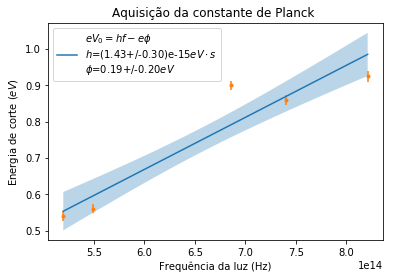

(1.432508826682494e-15+/-2.991144890162761e-16,
 0.19091752051012736+/-0.19929523142867248)

In [30]:
final(resultadao, 4, "sem1")

In [38]:
aff = []

for semana in ["sem1", "sem2", "sem3"]:
    for metodo in [1.0, 2.0, 3.0, 4.0]:
        texto = "Tomada {}, Método {}".format(semana, metodo)
        savefile = os.path.join(output_path, "Exp1_{}_m{}.jpg".format(semana, metodo))
        out = final(resultadao, metodo, semana, extratext=texto, savefile=savefile)
        aff.append({"Planck": out[0], "Função_Trabalho": out[1], "Semana": semana, "Metodo": metodo})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt


In [40]:
zzz = pd.DataFrame(aff, index=None).reindex(["Planck", "Função_Trabalho", "Metodo", "Semana"], axis=1)
zzz.to_html(os.path.join(output_path, "Resultado_V0_mixado.html"))

In [34]:
def super_final(resultadao, metodo, extratext="", savefile=""):   
    resultador = resultadao.copy()
    for semana in ["sem1", "sem2", "sem3"]:
        sem_luz_dict = {}
        if semana == "sem1":
            sem_luz_dict = sem1_luz_dict
        elif semana == "sem2":
            sem_luz_dict = sem2_luz_dict
        elif semana == "sem3":
            sem_luz_dict = sem3_luz_dict 
        resultador = resultador.replace(sem_luz_dict)
    resultador.head(45)

    a = resultador.groupby(["Luz", "Metodo"]).apply(lambda x : np.sum(x.V0) / len(x.V0))
     
    aaa = a.loc[:, metodo].reset_index(name="V0")

    c = 299792458 # m/s
    e = 1.60217662e-19 # C
    
    x = aaa.Luz
    y = -aaa.V0    
    
    inds = np.isfinite(unp.nominal_values(x))
    inds &= np.isfinite(unp.std_devs(x))
    inds &= unp.std_devs(x) > 0
    inds &= np.isfinite(unp.nominal_values(y)) 
    inds &= np.isfinite(unp.std_devs(y))
    inds &= unp.std_devs(y) > 0

    xerr = unp.std_devs(x[inds])
    x = unp.nominal_values(x[inds])
    yerr = unp.std_devs(y[inds])
    y = unp.nominal_values(y[inds])

    x = c / x
    
    fit = opt.curve_fit(lambda x, a, b: a * x + b, x, y, sigma=yerr)
    xx = np.linspace(x.min(), x.max(), 100)
    y_f = apply_fit(linear_function, xx, fit)
    planck = unc.ufloat(fit[0][0], np.sqrt(fit[1][0, 0]))
    trab = -unc.ufloat(fit[0][1], np.sqrt(fit[1][1, 1]))
    plt.plot(xx, y_f[0], '-', label="$eV_0=hf-e\phi$\n$h$={}$eV\cdot s$\n$\phi$={}$eV$".format(planck, trab))
    plt.fill_between(xx, y_f[0]-y_f[1], y_f[0] + y_f[1], alpha=0.3)
    plt.xlabel("Frequência da luz (Hz)")
    plt.ylabel("Energia de corte ($eV$)")
    plt.title("Aquisição da constante de Planck {}".format(extratext))
    plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt=".")
    plt.legend()
    if (savefile != ""):
        plt.savefig(savefile, odpi=300)
        plt.close()
    else:
        print("Plank: {} \n Funcao trabalho: {}".format(planck, trab))
        plt.show()  
    return (planck, trab)

In [35]:
aff2 = []

for metodo in [1, 2, 3, 4]:
    path = os.path.join(output_path, "Exp1_m{}.jpg".format(metodo))
    txt = "Método {} - todos os dados"
    out = super_final(resultadao, metodo, extratext=txt, savefile=path)
    aff2.append({"Metodo": metodo, "Planck": out[0], "Trab": out[1]})

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.6/dist-packages/uncertainties/core.py:164: RuntimeWarning: invalid value encountered in less
  variances[variances < 0] = 0.


In [36]:
zxz = pd.DataFrame(aff2)
zxz.to_html(os.path.join(output_path, "Resultado_ACABOU.html"))

Plank: (4.2+/-0.5)e-15 
 Funcao trabalho: 1.74+/-0.27


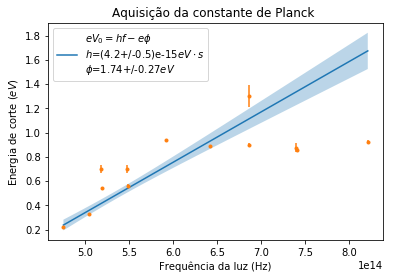

(4.155050911981836e-15+/-5.088592987298592e-16,
 1.7389316672466004+/-0.2739955357778861)

In [37]:
super_final(resultadao, metodo=4)